<a href="https://colab.research.google.com/github/Saeed-Akbari/CS5783-MachineLearning/blob/main/Assignment3/problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# import required packages.

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from  torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
#from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
#from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split

from torchsummary import summary

In [180]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders
#and move data to the selected device, as a batches are accessed.
#Interestingly, we don't need to extend an existing class to create a PyTorch
#dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and
#an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [181]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [182]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [183]:
# It deactivates the autograd engine (tracking of gradients) to
# reduce memory usage and boost computational speed.
@torch.no_grad()
def evaluate(model, val_loader):
    # batchnorm or dropout layers will work in eval mode instead of training mode
    model.eval()
    # Calculate loss on data coming from validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    # scheduler = OneCycleLR(optimizer, lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            # Calculate loss on data coming from training set
            loss = model.training_step(batch)
            # keep all losses on different batches of training data
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # model.epoch_end(epoch, result,scheduler.get_lr())
        model.epoch_end(epoch, result,lr)
        history.append(result)
    return history

In [184]:
# downloading CIFAR10 dataset (both training and test sets)

torch.manual_seed(1)

dataset = CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [185]:
# calculate accuracy by counting the number of true predictions and dividing it
# to the whole number of predictions.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [186]:
# This class is parent for the next class "MnistModel".
# This class ingeritance from "torch.nn.Module" class.

class MnistModelBase(torch.nn.Module):
    # Calculate loss on training set
    def training_step(self, batch):
        images, targets = batch   # extracting features and labels
        out = self(images)        # calculate the output or yhat
        loss = F.cross_entropy(out, targets)  # calculate loss function
        return loss     # return loss
    
    # Calculate loss on validation set
    def validation_step(self, batch):
        images, targets = batch    # extracting features and labels
        out = self(images)        # calculate the output or yhat
        loss = F.cross_entropy(out, targets)  # Calculate loss
        # calculate the accuracy based on the function I already defined in the above cells
        acc = accuracy(out, targets)
        # return a dictionary including loss and accuracy of validation set
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # show some metrics during training
    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))

In [187]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel1(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 6, 5, stride=1, padding='same')  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(6, 16, 5, stride=1, padding='same')
        self.conv3 = torch.nn.Conv2d(16, 120, 5, stride=1, padding='same')

        self.pool = torch.nn.MaxPool2d(2, stride=2)

        self.relu = torch.nn.ReLU()

        #self.fc1 = torch.nn.Linear(120, 60)
        self.fc1 = torch.nn.Linear(7680, 128)
        self.fc2 = torch.nn.Linear(128, 10)  # 10 classes
        self.softmax = torch.nn.Softmax()

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [204]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [205]:
# size of training set is the total size minus the size of val set
train_size = len(dataset) - val_size

# split dataset between two training and validation sets.
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [206]:
# create three tensors for trainin, validation, and test sets

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

torch.Size([3, 32, 32])


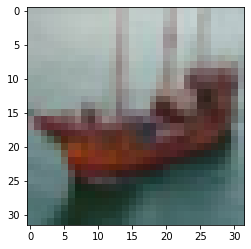

In [54]:
# This cell calculates min, max, mean, and standard deviation of training set
# It shows first training data
   
imgs, lbls = next(iter(train_loader))
print(imgs[7].data.shape)
img = make_grid(imgs[0])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [207]:
# choose the default device.
# It takes GPU if it is available. Otherwise, it takes CPU.
device = get_default_device()

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [56]:
# Model (on GPU)
model1 = MnistModel1()
to_device(model1, device)

MnistModel1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=7680, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

In [57]:
# print the summary of the model
summary(model1, input_size=(3, 32, 32), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,416
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7            [-1, 120, 8, 8]          48,120
              ReLU-8            [-1, 120, 8, 8]               0
            Linear-9                  [-1, 128]         983,168
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 1,035,450
Trainable params: 1,035,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [58]:
history1 = [evaluate(model1, val_loader)]
history1 += fit(epochs, lr, model1, train_loader, val_loader, opt)

Epoch [0] - LR [0.001], train_loss: 1.7449, val_loss: 1.5144, val_acc: 0.4437
Epoch [1] - LR [0.001], train_loss: 1.4013, val_loss: 1.3468, val_acc: 0.5146
Epoch [2] - LR [0.001], train_loss: 1.2336, val_loss: 1.2229, val_acc: 0.5573
Epoch [3] - LR [0.001], train_loss: 1.1138, val_loss: 1.1275, val_acc: 0.5998
Epoch [4] - LR [0.001], train_loss: 1.0221, val_loss: 1.0530, val_acc: 0.6258
Epoch [5] - LR [0.001], train_loss: 0.9265, val_loss: 0.9955, val_acc: 0.6453
Epoch [6] - LR [0.001], train_loss: 0.8634, val_loss: 0.9707, val_acc: 0.6540
Epoch [7] - LR [0.001], train_loss: 0.7967, val_loss: 0.9746, val_acc: 0.6553
Epoch [8] - LR [0.001], train_loss: 0.7286, val_loss: 0.9315, val_acc: 0.6785
Epoch [9] - LR [0.001], train_loss: 0.6691, val_loss: 0.9822, val_acc: 0.6624
Epoch [10] - LR [0.001], train_loss: 0.6087, val_loss: 0.9463, val_acc: 0.6839
Epoch [11] - LR [0.001], train_loss: 0.5470, val_loss: 0.9828, val_acc: 0.6752
Epoch [12] - LR [0.001], train_loss: 0.4934, val_loss: 1.0006,

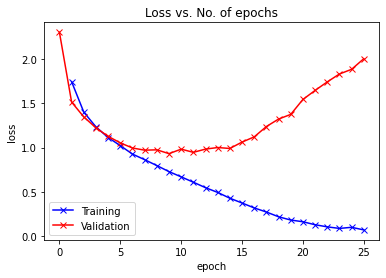

In [59]:
plot_losses(history1)

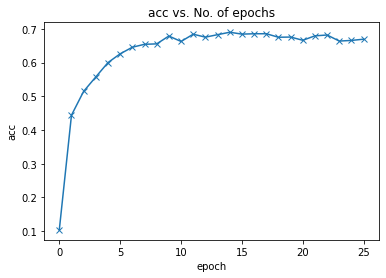

In [60]:
plot_scores(history1)

In [61]:
# loss and accuracy of last epochs
print(history1[-1])

{'val_loss': 2.0039925575256348, 'val_acc': 0.669140636920929, 'train_loss': 0.06971785426139832}


In [62]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.SGD     # optimizer

In [63]:
# training the network
model2 = MnistModel1()
to_device(model2, device)
history2 = [evaluate(model2, val_loader)]
history2 += fit(epochs, lr, model2, train_loader, val_loader, opt)

Epoch [0] - LR [0.001], train_loss: 2.3038, val_loss: 2.3042, val_acc: 0.0980
Epoch [1] - LR [0.001], train_loss: 2.3035, val_loss: 2.3039, val_acc: 0.0979
Epoch [2] - LR [0.001], train_loss: 2.3032, val_loss: 2.3037, val_acc: 0.0982
Epoch [3] - LR [0.001], train_loss: 2.3030, val_loss: 2.3034, val_acc: 0.0989
Epoch [4] - LR [0.001], train_loss: 2.3028, val_loss: 2.3032, val_acc: 0.0996
Epoch [5] - LR [0.001], train_loss: 2.3026, val_loss: 2.3030, val_acc: 0.1001
Epoch [6] - LR [0.001], train_loss: 2.3024, val_loss: 2.3028, val_acc: 0.1006
Epoch [7] - LR [0.001], train_loss: 2.3023, val_loss: 2.3027, val_acc: 0.1009
Epoch [8] - LR [0.001], train_loss: 2.3021, val_loss: 2.3025, val_acc: 0.1022
Epoch [9] - LR [0.001], train_loss: 2.3019, val_loss: 2.3023, val_acc: 0.1062
Epoch [10] - LR [0.001], train_loss: 2.3017, val_loss: 2.3021, val_acc: 0.1093
Epoch [11] - LR [0.001], train_loss: 2.3015, val_loss: 2.3018, val_acc: 0.1103
Epoch [12] - LR [0.001], train_loss: 2.3013, val_loss: 2.3016,

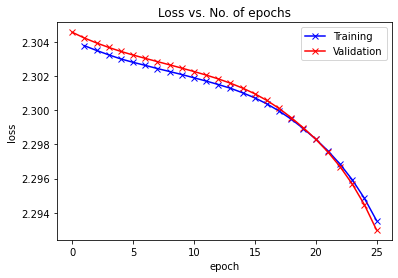

In [64]:
# plot losses
plot_losses(history2)

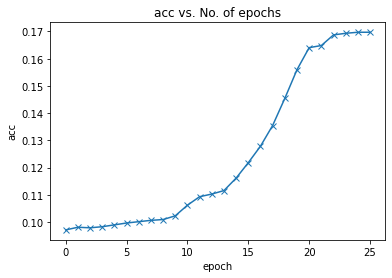

In [66]:
plot_scores(history2)

In [65]:
# loss and accuracy of last epochs
print(history2[-1])

{'val_loss': 2.2929904460906982, 'val_acc': 0.16972656548023224, 'train_loss': 2.293541669845581}


In [67]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.01      # learning rate
opt = torch.optim.Adam     # optimizer

In [68]:
# training the network
model3 = MnistModel1()
to_device(model3, device)
history3 = [evaluate(model3, val_loader)]
history3 += fit(epochs, lr, model3, train_loader, val_loader, opt)

Epoch [0] - LR [0.01], train_loss: 2.3357, val_loss: 2.3034, val_acc: 0.0976
Epoch [1] - LR [0.01], train_loss: 2.3033, val_loss: 2.3040, val_acc: 0.0993
Epoch [2] - LR [0.01], train_loss: 2.3033, val_loss: 2.3038, val_acc: 0.0978
Epoch [3] - LR [0.01], train_loss: 2.3032, val_loss: 2.3027, val_acc: 0.0971
Epoch [4] - LR [0.01], train_loss: 2.3034, val_loss: 2.3028, val_acc: 0.0993
Epoch [5] - LR [0.01], train_loss: 2.3033, val_loss: 2.3033, val_acc: 0.0967
Epoch [6] - LR [0.01], train_loss: 2.3032, val_loss: 2.3036, val_acc: 0.0971
Epoch [7] - LR [0.01], train_loss: 2.3035, val_loss: 2.3036, val_acc: 0.0953
Epoch [8] - LR [0.01], train_loss: 2.3032, val_loss: 2.3037, val_acc: 0.0976
Epoch [9] - LR [0.01], train_loss: 2.3032, val_loss: 2.3044, val_acc: 0.0967
Epoch [10] - LR [0.01], train_loss: 2.3032, val_loss: 2.3034, val_acc: 0.0993
Epoch [11] - LR [0.01], train_loss: 2.3032, val_loss: 2.3036, val_acc: 0.0993
Epoch [12] - LR [0.01], train_loss: 2.3034, val_loss: 2.3039, val_acc: 0.0

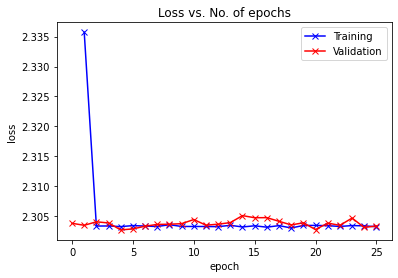

In [69]:
# plot losses
plot_losses(history3)

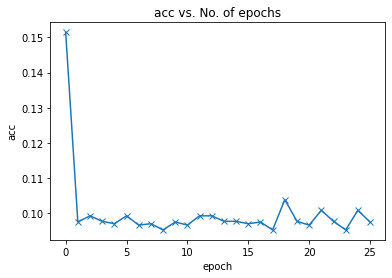

In [70]:
plot_scores(history3)

In [71]:
# loss and accuracy of last epochs
print(history3[-1])

{'val_loss': 2.303316116333008, 'val_acc': 0.09755859524011612, 'train_loss': 2.3031842708587646}


In [72]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.0001      # learning rate
opt = torch.optim.Adam     # optimizer

In [73]:
# training the network
model4 = MnistModel1()
to_device(model4, device)
history4 = [evaluate(model4, val_loader)]
history4 += fit(epochs, lr, model4, train_loader, val_loader, opt)

Epoch [0] - LR [0.0001], train_loss: 2.0431, val_loss: 1.8829, val_acc: 0.3002
Epoch [1] - LR [0.0001], train_loss: 1.7797, val_loss: 1.7298, val_acc: 0.3669
Epoch [2] - LR [0.0001], train_loss: 1.6656, val_loss: 1.6290, val_acc: 0.4034
Epoch [3] - LR [0.0001], train_loss: 1.5936, val_loss: 1.5759, val_acc: 0.4248
Epoch [4] - LR [0.0001], train_loss: 1.5422, val_loss: 1.5394, val_acc: 0.4381
Epoch [5] - LR [0.0001], train_loss: 1.5018, val_loss: 1.4963, val_acc: 0.4540
Epoch [6] - LR [0.0001], train_loss: 1.4655, val_loss: 1.4893, val_acc: 0.4628
Epoch [7] - LR [0.0001], train_loss: 1.4367, val_loss: 1.4418, val_acc: 0.4813
Epoch [8] - LR [0.0001], train_loss: 1.4086, val_loss: 1.4282, val_acc: 0.4821
Epoch [9] - LR [0.0001], train_loss: 1.3844, val_loss: 1.3901, val_acc: 0.4949
Epoch [10] - LR [0.0001], train_loss: 1.3588, val_loss: 1.3824, val_acc: 0.4994
Epoch [11] - LR [0.0001], train_loss: 1.3372, val_loss: 1.3546, val_acc: 0.5131
Epoch [12] - LR [0.0001], train_loss: 1.3212, val_

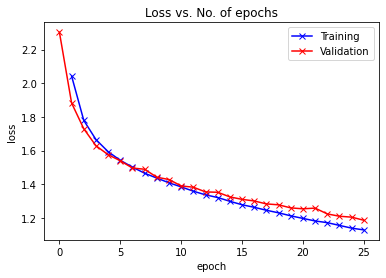

In [74]:
# plot losses
plot_losses(history4)

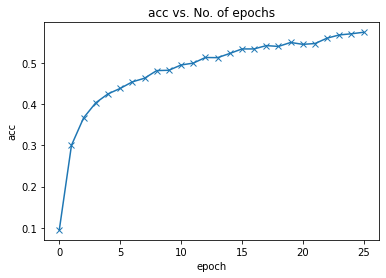

In [75]:
plot_scores(history4)

In [76]:
# loss and accuracy of last epochs
print(history4[-1])

{'val_loss': 1.1861525774002075, 'val_acc': 0.5743163824081421, 'train_loss': 1.1286729574203491}


In [79]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 40     # number of epochs
lr = 0.0001      # learning rate
opt = torch.optim.Adam     # optimizer

In [80]:
# training the network
model5 = MnistModel1()
to_device(model5, device)
history5 = [evaluate(model5, val_loader)]
history5 += fit(epochs, lr, model5, train_loader, val_loader, opt)

Epoch [0] - LR [0.0001], train_loss: 2.0295, val_loss: 1.8679, val_acc: 0.3218
Epoch [1] - LR [0.0001], train_loss: 1.7775, val_loss: 1.7105, val_acc: 0.3850
Epoch [2] - LR [0.0001], train_loss: 1.6669, val_loss: 1.6284, val_acc: 0.4029
Epoch [3] - LR [0.0001], train_loss: 1.5997, val_loss: 1.5703, val_acc: 0.4265
Epoch [4] - LR [0.0001], train_loss: 1.5435, val_loss: 1.5209, val_acc: 0.4489
Epoch [5] - LR [0.0001], train_loss: 1.4926, val_loss: 1.4778, val_acc: 0.4626
Epoch [6] - LR [0.0001], train_loss: 1.4529, val_loss: 1.4637, val_acc: 0.4699
Epoch [7] - LR [0.0001], train_loss: 1.4217, val_loss: 1.4340, val_acc: 0.4886
Epoch [8] - LR [0.0001], train_loss: 1.3946, val_loss: 1.4092, val_acc: 0.4889
Epoch [9] - LR [0.0001], train_loss: 1.3713, val_loss: 1.3886, val_acc: 0.4970
Epoch [10] - LR [0.0001], train_loss: 1.3521, val_loss: 1.3569, val_acc: 0.5157
Epoch [11] - LR [0.0001], train_loss: 1.3297, val_loss: 1.3697, val_acc: 0.5070
Epoch [12] - LR [0.0001], train_loss: 1.3102, val_

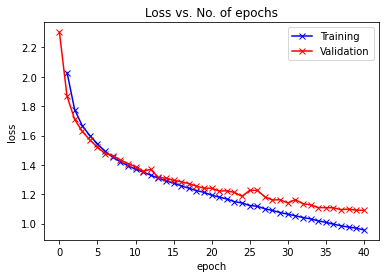

In [81]:
# plot losses
plot_losses(history5)

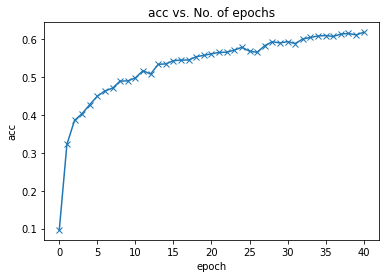

In [82]:
plot_scores(history5)

In [83]:
# loss and accuracy of last epochs
print(history5[-1])

{'val_loss': 1.0906273126602173, 'val_acc': 0.6170898675918579, 'train_loss': 0.9572048783302307}


**1. What is the effect of learning rate on the training process? Which performed best?**
The LeNet model is trained for three different learning rates. The below cell shows the accuracy for these three learning rates. Bigger learning rate $0.01$ gives poor accuracy around $0.097$ on the validation set. The learning rate $0.001$ gives a little bit better accuracy than $0.0001$ for the epoch number $25$. Increasing the epoch number from $25$ to $40$ for learning rate $0.0001$ shows that higher epoch number give better accuracy.

In [136]:
print("lr:0.001, epoch:25", history1[-1])
print("lr:0.01, epoch:25", history3[-1])
print("lr:0.0001, epoch:25", history4[-1])
print("lr:0.0001, epoch:40", history5[-1])

lr:0.001, epoch:25 {'val_loss': 2.0039925575256348, 'val_acc': 0.669140636920929, 'train_loss': 0.06971785426139832}
lr:0.01, epoch:25 {'val_loss': 2.303316116333008, 'val_acc': 0.09755859524011612, 'train_loss': 2.3031842708587646}
lr:0.0001, epoch:25 {'val_loss': 1.1861525774002075, 'val_acc': 0.5743163824081421, 'train_loss': 1.1286729574203491}
lr:0.0001, epoch:40 {'val_loss': 1.0906273126602173, 'val_acc': 0.6170898675918579, 'train_loss': 0.9572048783302307}


In [84]:
# Hyper parameters

batch_size = 512      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [85]:
# create three tensors for trainin, validation, and test sets

train_loader2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader2 = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader2 = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

# choose the default device.
# It takes GPU if it is available. Otherwise, it takes CPU.
device2 = get_default_device()

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader2 = DeviceDataLoader(train_loader2, device2)
val_loader2 = DeviceDataLoader(val_loader2, device2)
test_loader2 = DeviceDataLoader(test_loader2, device2)

In [87]:
model6 = MnistModel1()
to_device(model6, device2)

history6 = [evaluate(model6, val_loader2)]
history6 += fit(epochs, lr, model6, train_loader2, val_loader2, opt)

Epoch [0] - LR [0.001], train_loss: 1.8815, val_loss: 1.6834, val_acc: 0.3842
Epoch [1] - LR [0.001], train_loss: 1.5657, val_loss: 1.5133, val_acc: 0.4471
Epoch [2] - LR [0.001], train_loss: 1.4416, val_loss: 2.0833, val_acc: 0.3252
Epoch [3] - LR [0.001], train_loss: 1.4154, val_loss: 1.3736, val_acc: 0.5050
Epoch [4] - LR [0.001], train_loss: 1.3001, val_loss: 1.3286, val_acc: 0.5182
Epoch [5] - LR [0.001], train_loss: 1.2327, val_loss: 1.2727, val_acc: 0.5443
Epoch [6] - LR [0.001], train_loss: 1.1853, val_loss: 1.2156, val_acc: 0.5581
Epoch [7] - LR [0.001], train_loss: 1.1359, val_loss: 1.2488, val_acc: 0.5537
Epoch [8] - LR [0.001], train_loss: 1.0954, val_loss: 1.2831, val_acc: 0.5503
Epoch [9] - LR [0.001], train_loss: 1.0587, val_loss: 1.1405, val_acc: 0.5926
Epoch [10] - LR [0.001], train_loss: 1.0061, val_loss: 1.1222, val_acc: 0.6015
Epoch [11] - LR [0.001], train_loss: 0.9583, val_loss: 1.0956, val_acc: 0.6109
Epoch [12] - LR [0.001], train_loss: 0.9275, val_loss: 1.0614,

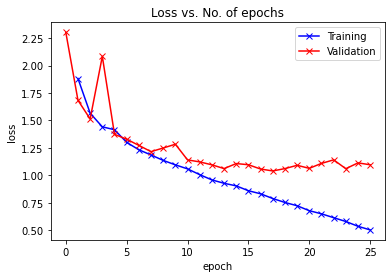

In [88]:
# plot losses
plot_losses(history6)

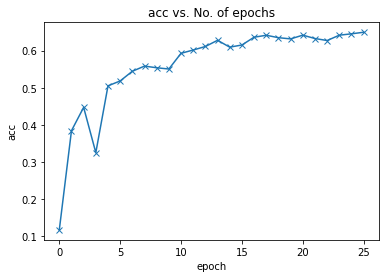

In [89]:
plot_scores(history6)

In [90]:
# loss and accuracy of last epochs
print(history6[-1])

{'val_loss': 1.0961675643920898, 'val_acc': 0.6492606401443481, 'train_loss': 0.5028433203697205}


In [91]:
# Hyper parameters

batch_size = 16      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [92]:
# create three tensors for trainin, validation, and test sets

train_loader3 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader3 = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader3 = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

# choose the default device.
# It takes GPU if it is available. Otherwise, it takes CPU.
device3 = get_default_device()

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader3 = DeviceDataLoader(train_loader3, device3)
val_loader3 = DeviceDataLoader(val_loader3, device3)
test_loader3 = DeviceDataLoader(test_loader3, device3)

In [93]:
model7 = MnistModel1()
to_device(model7, device3)

history7 = [evaluate(model7, val_loader3)]
history7 += fit(epochs, lr, model7, train_loader3, val_loader3, opt)

Epoch [0] - LR [0.001], train_loss: 1.5747, val_loss: 1.3322, val_acc: 0.5209
Epoch [1] - LR [0.001], train_loss: 1.2021, val_loss: 1.1943, val_acc: 0.5729
Epoch [2] - LR [0.001], train_loss: 1.0161, val_loss: 1.1005, val_acc: 0.6121
Epoch [3] - LR [0.001], train_loss: 0.8721, val_loss: 1.0973, val_acc: 0.6183
Epoch [4] - LR [0.001], train_loss: 0.7337, val_loss: 1.0646, val_acc: 0.6422
Epoch [5] - LR [0.001], train_loss: 0.5992, val_loss: 1.1372, val_acc: 0.6400
Epoch [6] - LR [0.001], train_loss: 0.4745, val_loss: 1.2672, val_acc: 0.6344
Epoch [7] - LR [0.001], train_loss: 0.3726, val_loss: 1.4041, val_acc: 0.6300
Epoch [8] - LR [0.001], train_loss: 0.2988, val_loss: 1.6227, val_acc: 0.6295
Epoch [9] - LR [0.001], train_loss: 0.2448, val_loss: 1.8153, val_acc: 0.6200
Epoch [10] - LR [0.001], train_loss: 0.2030, val_loss: 1.9532, val_acc: 0.6165
Epoch [11] - LR [0.001], train_loss: 0.1898, val_loss: 2.2637, val_acc: 0.6080
Epoch [12] - LR [0.001], train_loss: 0.1657, val_loss: 2.3620,

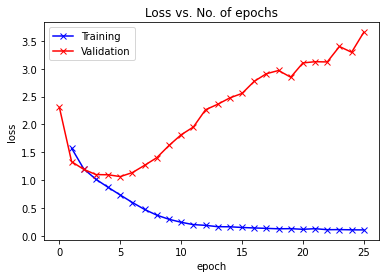

In [94]:
# plot losses
plot_losses(history7)

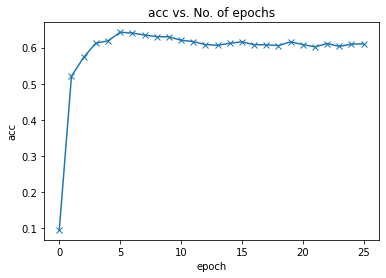

In [95]:
plot_scores(history7)

In [96]:
# loss and accuracy of last epochs
print(history7[-1])

{'val_loss': 3.65442156791687, 'val_acc': 0.6103234887123108, 'train_loss': 0.10778572410345078}


**2. What is the effect of batch size on the training process? Which performed best?**
The model is trained with three different batch sizes. A batch size:$128$ gives the best performance with the accuracy on the validation set around $0.669$. Increasing the batch size to $512$ causes the accuracy on the validation set to be a little bit lower around $0.649$. The batch size $16$ gives poor accuracy around $0.61$.

In [137]:
print("batch size:128", history1[-1])
print("batch size:512", history6[-1])
print("batch size:16", history7[-1])

batch size:128 {'val_loss': 2.0039925575256348, 'val_acc': 0.669140636920929, 'train_loss': 0.06971785426139832}
batch size:512 {'val_loss': 1.0961675643920898, 'val_acc': 0.6492606401443481, 'train_loss': 0.5028433203697205}
batch size:16 {'val_loss': 3.65442156791687, 'val_acc': 0.6103234887123108, 'train_loss': 0.10778572410345078}


In [97]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [111]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel2(MnistModelBase):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 16, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 32, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout2d(0.1),
        )

        # translation layer
        self.trans1 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 20, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(20),


            # RF - 14x14
            torch.nn.MaxPool2d(2, 2),
        )

        self.conv2 = torch.nn.Sequential(
            
            torch.nn.Conv2d(20,20,3,padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(20),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(20,16,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),

            torch.nn.Conv2d(16, 16, 3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),
        ) 

         
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16,16,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout2d(0.1),
        )   

        # GAP Layer
        self.avg_pool = torch.nn.Sequential(
            # # RF - 22x22
            torch.nn.AvgPool2d(5)
        )   ## output_size=1  

        self.conv4 = torch.nn.Sequential(
  
            torch.nn.Conv2d(16,10,1),

        )  

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)
        x = self.conv4(x)

        x = x.view(-1, 10)
        return x

In [112]:
model8 = MnistModel2()
to_device(model8, device)

MnistModel2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), s

In [113]:
# print the summary of the model
summary(model8, input_size=(3, 32, 32), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
         Dropout2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 16, 28, 28]           2,320
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           4,640
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
        Dropout2d-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 20, 26, 26]             660
             ReLU-14           [-1, 20,

In [114]:
history8 = [evaluate(model8, val_loader)]
history8 += fit(epochs, lr, model8, train_loader, val_loader, opt)

Epoch [0] - LR [0.001], train_loss: 1.8196, val_loss: 1.5359, val_acc: 0.4412
Epoch [1] - LR [0.001], train_loss: 1.5113, val_loss: 1.3291, val_acc: 0.5191
Epoch [2] - LR [0.001], train_loss: 1.3859, val_loss: 1.2443, val_acc: 0.5533
Epoch [3] - LR [0.001], train_loss: 1.3033, val_loss: 1.1479, val_acc: 0.5826
Epoch [4] - LR [0.001], train_loss: 1.2628, val_loss: 1.1127, val_acc: 0.5939
Epoch [5] - LR [0.001], train_loss: 1.2257, val_loss: 1.0828, val_acc: 0.6093
Epoch [6] - LR [0.001], train_loss: 1.1978, val_loss: 1.0498, val_acc: 0.6189
Epoch [7] - LR [0.001], train_loss: 1.1732, val_loss: 1.0276, val_acc: 0.6304
Epoch [8] - LR [0.001], train_loss: 1.1519, val_loss: 1.0026, val_acc: 0.6408
Epoch [9] - LR [0.001], train_loss: 1.1320, val_loss: 1.0254, val_acc: 0.6312
Epoch [10] - LR [0.001], train_loss: 1.1161, val_loss: 0.9803, val_acc: 0.6495
Epoch [11] - LR [0.001], train_loss: 1.1040, val_loss: 0.9867, val_acc: 0.6518
Epoch [12] - LR [0.001], train_loss: 1.0845, val_loss: 0.9652,

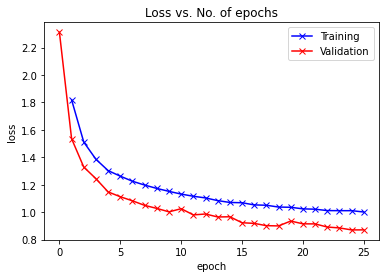

In [115]:
# plot losses
plot_losses(history8)

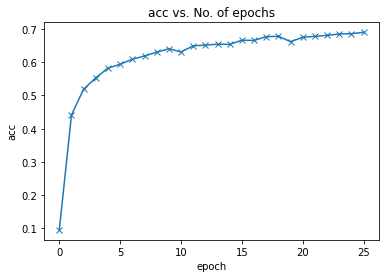

In [116]:
plot_scores(history8)

In [117]:
# loss and accuracy of last epochs
print(history8[-1])

{'val_loss': 0.8709522485733032, 'val_acc': 0.6904296875, 'train_loss': 1.0012873411178589}


In [118]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [128]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel3(MnistModelBase):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),

            torch.nn.Conv2d(32, 32, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.2),
        )


        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 64, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.3),
        )


        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, padding='same', kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 128, 3, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Dropout2d(0.4),
        )


        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.Linear(512, 64),
            torch.nn.Linear(64, 10),  # 10 classes
        )

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [129]:
model9 = MnistModel3()
to_device(model9, device)

MnistModel3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2

In [130]:
# print the summary of the model
summary(model9, input_size=(3, 32, 32), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

In [131]:
history9 = [evaluate(model9, val_loader)]
history9 += fit(epochs, lr, model9, train_loader, val_loader, opt)

Epoch [0] - LR [0.001], train_loss: 1.5701, val_loss: 1.1936, val_acc: 0.5705
Epoch [1] - LR [0.001], train_loss: 1.1355, val_loss: 1.0168, val_acc: 0.6348
Epoch [2] - LR [0.001], train_loss: 0.9431, val_loss: 0.8308, val_acc: 0.7094
Epoch [3] - LR [0.001], train_loss: 0.8365, val_loss: 0.7838, val_acc: 0.7295
Epoch [4] - LR [0.001], train_loss: 0.7558, val_loss: 0.7058, val_acc: 0.7512
Epoch [5] - LR [0.001], train_loss: 0.7105, val_loss: 0.6627, val_acc: 0.7708
Epoch [6] - LR [0.001], train_loss: 0.6581, val_loss: 0.6677, val_acc: 0.7683
Epoch [7] - LR [0.001], train_loss: 0.6211, val_loss: 0.6206, val_acc: 0.7860
Epoch [8] - LR [0.001], train_loss: 0.5888, val_loss: 0.6039, val_acc: 0.7979
Epoch [9] - LR [0.001], train_loss: 0.5521, val_loss: 0.6553, val_acc: 0.7792
Epoch [10] - LR [0.001], train_loss: 0.5287, val_loss: 0.5980, val_acc: 0.8053
Epoch [11] - LR [0.001], train_loss: 0.5129, val_loss: 0.5717, val_acc: 0.8100
Epoch [12] - LR [0.001], train_loss: 0.4867, val_loss: 0.6217,

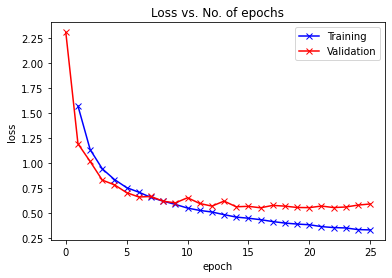

In [132]:
# plot losses
plot_losses(history9)

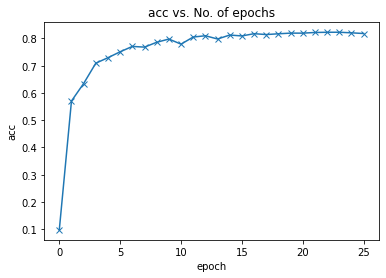

In [133]:
plot_scores(history9)

In [134]:
# loss and accuracy of last epochs
print(history9[-1])

{'val_loss': 0.5931171178817749, 'val_acc': 0.818164050579071, 'train_loss': 0.33438849449157715}


**3. Try different hyperparameters to obtain the best accuracy on the test set. What is your best performance and what were the hyperparameters?**

I have trained LeNet model with different learning rate, batch size, optimizer. 
I got the best performance for the batch size:$128$, learning rate:$0.001$, optimizer:Adam with the accuracy around $0.669$.
I have also trained model with different kernel size, number of kernels and with adding batch normalization layers and drop out layers. The model with new architecture give the accuracy around $0.818$.

In [213]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 25     # number of epochs
lr = 0.001      # learning rate
opt = torch.optim.Adam     # optimizer

In [214]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class CifarModelMLP(MnistModelBase):
    def __init__(self):
        super().__init__()

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(3072, 6)
        self.fc2 = torch.nn.Linear(6, 16)
        self.fc3 = torch.nn.Linear(16, 120)
        self.fc4 = torch.nn.Linear(120, 84)
        self.fc5 = torch.nn.Linear(84, 10)

    def forward(self, xb):

        # MLP
        x = xb.view(xb.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)

        return x

In [215]:
# create three tensors for trainin, validation, and test sets

train_loader5 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader5 = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_loader5 = DataLoader(test_dataset, batch_size*2, num_workers=0, pin_memory=True)

device5 = get_default_device()

train_loader5 = DeviceDataLoader(train_loader5, device5)
val_loader5 = DeviceDataLoader(val_loader5, device5)
test_loader5 = DeviceDataLoader(test_loader5, device5)

In [216]:
model10 = CifarModelMLP()
to_device(model10, device5)

CifarModelMLP(
  (relu): ReLU()
  (fc1): Linear(in_features=3072, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=84, bias=True)
  (fc5): Linear(in_features=84, out_features=10, bias=True)
)

In [217]:
# print the summary of the model
summary(model10, input_size=(3, 32, 32), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 6]          18,438
              ReLU-2                    [-1, 6]               0
            Linear-3                   [-1, 16]             112
              ReLU-4                   [-1, 16]               0
            Linear-5                  [-1, 120]           2,040
              ReLU-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
              ReLU-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 31,604
Trainable params: 31,604
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.14
---------------------------------------------

In [218]:
history10 = [evaluate(model10, val_loader5)]
history10 += fit(epochs, lr, model10, train_loader5, val_loader5, opt)

Epoch [0] - LR [0.001], train_loss: 2.1240, val_loss: 2.0869, val_acc: 0.1794
Epoch [1] - LR [0.001], train_loss: 2.0720, val_loss: 2.0639, val_acc: 0.1854
Epoch [2] - LR [0.001], train_loss: 2.0627, val_loss: 2.0581, val_acc: 0.1870
Epoch [3] - LR [0.001], train_loss: 2.0606, val_loss: 2.0653, val_acc: 0.1879
Epoch [4] - LR [0.001], train_loss: 2.0542, val_loss: 2.0511, val_acc: 0.1878
Epoch [5] - LR [0.001], train_loss: 2.0549, val_loss: 2.0599, val_acc: 0.1899
Epoch [6] - LR [0.001], train_loss: 2.0541, val_loss: 2.0690, val_acc: 0.1875
Epoch [7] - LR [0.001], train_loss: 2.0487, val_loss: 2.0507, val_acc: 0.1896
Epoch [8] - LR [0.001], train_loss: 2.0477, val_loss: 2.0651, val_acc: 0.1877
Epoch [9] - LR [0.001], train_loss: 2.0537, val_loss: 2.0448, val_acc: 0.1892
Epoch [10] - LR [0.001], train_loss: 2.0525, val_loss: 2.0498, val_acc: 0.1884
Epoch [11] - LR [0.001], train_loss: 2.0466, val_loss: 2.0625, val_acc: 0.1866
Epoch [12] - LR [0.001], train_loss: 2.0463, val_loss: 2.0438,

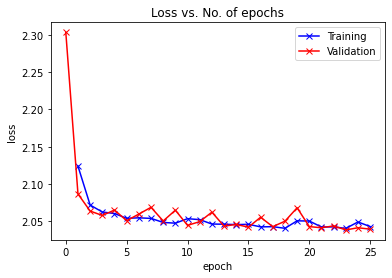

In [219]:
# plot losses
plot_losses(history10)

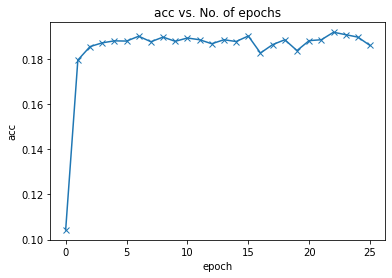

In [220]:
plot_scores(history10)

In [221]:
# loss and accuracy of last epochs
print(history10[-1])

{'val_loss': 2.0397541522979736, 'val_acc': 0.18583984673023224, 'train_loss': 2.043203830718994}


**4. Implement an equivalent feed forward network for the same task with each hidden layer containing the same number of neurons as the number of filters in each convolution layer.
Use the ‘Adam’ optimizer to train your network on the CIFAR-10 dataset for a fixed set of 25 epochs. Compare its performance with your LeNet implementation based on the following questions:**

**a. What is its performance?**

The accuracy of the multilayer perceptron is around $0.1858$ but the accuracy of the LeNet is around $0.6691$.

**b. How many parameters are there in this network compared to the LeNet
implementation? Are they worth it?**

Trainable params in MLP network: $31,604$

Trainable params in LeNet network: $1,035,450$

The number of parameters of the MLP network are much less than LeNet but its accuracy is also much less than LeNet. So, it is not worth it.